In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#font segoe ui
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Segoe UI'


#### Flow validation

In [25]:
src_dir = r"W:/VUB/_main_research/mHM/flow_data/waterinfo_csv/"
station_locations = pd.read_csv(src_dir + "mhm_flow_stations_coordinates.csv")

#select a station: change the index to select another station
station = station_locations.iloc[3,:]

observed = pd.read_csv(src_dir + f"{station.stat_name}_Q.csv", parse_dates=True, index_col=0, dayfirst=True)
sim_flow_mhm = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mRM_Fluxes_States.nc")
sim_flow_mhm_calib = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mRM_Fluxes_States_015625.nc")

#set -9999 to nan in observed data
observed[observed == -9999] = np.nan

In [20]:
station

stat_name    Gavere_Bovenschelde
lat                      50.9297
lon                       3.6541
code                         400
Name: 3, dtype: object

In [21]:
#extracting the simulated flow
mhm_flow_ts = sim_flow_mhm['Qrouted'].sel(lat = station.lat, lon = station.lon, method = 'nearest') 
mhm_flow_ts_calib = sim_flow_mhm_calib['Qrouted'].sel(lat = station.lat, lon = station.lon, method = 'nearest')
sim_flow = mhm_flow_ts.to_dataframe().drop(columns=['lat', 'lon'])
sim_flow_calib = mhm_flow_ts_calib.to_dataframe().drop(columns=['lat', 'lon'])
#flow_df = flow_df.resample('ME').mean()

#resample observed data to monthly
#observed_monthly = observed.resample('ME').mean()

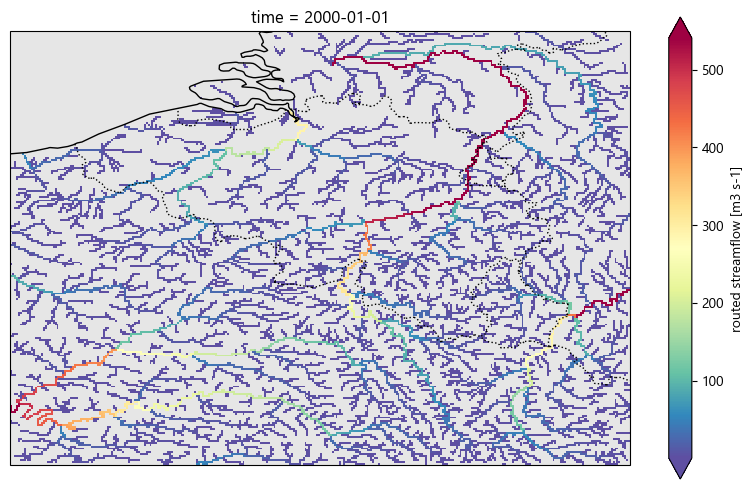

In [4]:
#sim_flow_mhm_calib['Qrouted'][0].plot(cmap='Spectral_r',robust=True)

# Assuming sim_flow_mhm_calib['Qrouted'][0] is your data array and it's correctly set up with coordinates
# Plot data where Qrouted is greater than 20
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))
flow_data = sim_flow_mhm_calib['Qrouted'][0].where(sim_flow_mhm_calib['Qrouted'][0] > 0.5)
flow_data.plot(ax=ax, cmap='Spectral_r', robust=True, transform=ccrs.PlateCarree())

# Add a background map
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAND, facecolor='0.9')
ax.add_feature(cartopy.feature.OCEAN, facecolor='0.9')
#ax.add_feature(cartopy.feature.LAKES, facecolor='0.9')
#ax.add_feature(cartopy.feature.RIVERS, edgecolor='blue')  # Changed to make rivers more visible
plt.show()


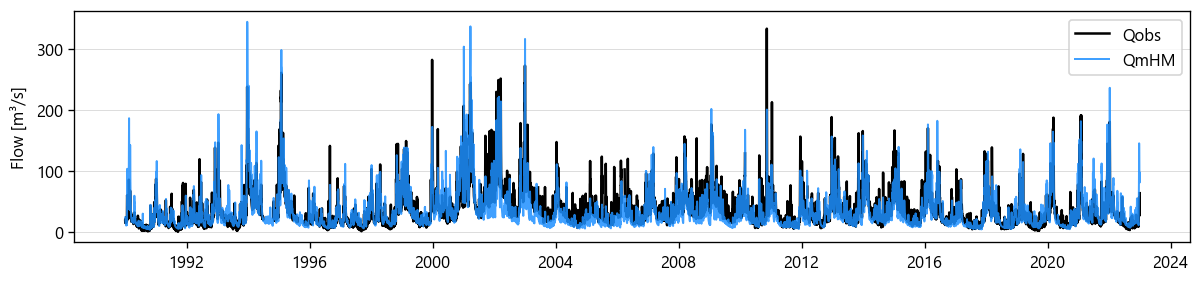

In [28]:
fig, ax = plt.subplots(figsize=(12, 2.5), dpi=120)
#ax2 = ax.twinx()
plt.plot(observed['1990-01-01':'2022-12-31'], c='k',lw=1.5, label='Qobs')
plt.plot(sim_flow['1990-01-01':'2022-12-31'], c='dodgerblue', lw=1.2, label='QmHM', alpha=0.85)
#plt.plot(sim_flow_calib['1995-01-01':'2000-12-31'], c='limegreen', lw=0.9, alpha=0.9, label='QmHM calibrated')

plt.grid(lw=0.5,alpha=0.5,axis='y')
plt.ylabel('Flow [m³/s]')
ax.legend();

In [6]:
#MODEL STATISTICS [Functionalize these]
nse = 1 - (np.sum((sim_flow['Qrouted'] - observed['Q'])**2) / np.sum((observed['Q'] - observed['Q'].mean())**2))
r2 = np.corrcoef(sim_flow['Qrouted'][sim_flow.index.min():sim_flow.index.max()], observed['Q'][sim_flow.index.min():sim_flow.index.max()])[0,1]**2
nse, r2

(0.7472557333521255, 0.7608489413796019)

In [7]:
#MODEL STATISTICS [Functionalize these]
nse = 1 - (np.sum((sim_flow['Qrouted'] - observed['Q'])**2) / np.sum((observed['Q'] - observed['Q'].mean())**2))
r2 = np.corrcoef(sim_flow['Qrouted'][sim_flow.index.min():sim_flow.index.max()], observed['Q'][sim_flow.index.min():sim_flow.index.max()])[0,1]**2
nse, r2

(0.7472557333521255, 0.7608489413796019)

Text(0.5, 0, 'observed flow')

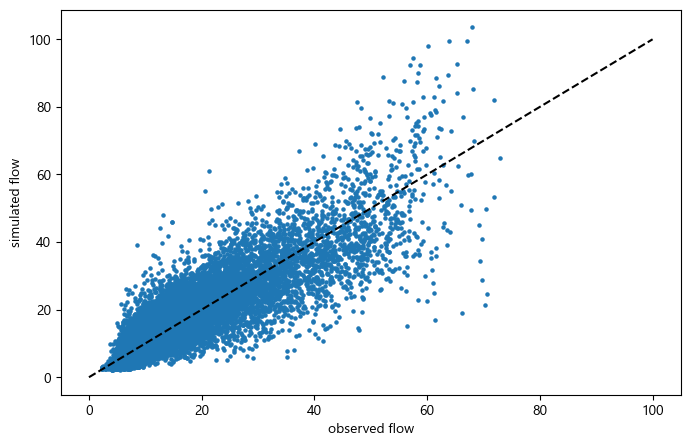

In [8]:
#scatter plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(observed['Q'][sim_flow.index.min():sim_flow.index.max()],
           sim_flow['Qrouted'][sim_flow.index.min():sim_flow_calib.index.max()], s=5,c='C10')
ax.plot([0, 100], [0, 100], 'k--')
ax.set_ylabel('simulated flow')
ax.set_xlabel('observed flow')

### Spatial Datasets

In [9]:
mhm_fluxes = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mHM_Fluxes_States.nc")
#resample to month ends
mhm_fluxes= mhm_fluxes.resample(time='ME').mean()
#Gleam root zone soil moisture
gleam_rzsm = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\gleam_EUR_SMrz_EAS_2000_2023.nc")

#### Soil Moisture

In [10]:
#Define ROI
roi = dict(lat=slice(51.5, 50.0), lon=slice(2.0, 3.5))

#extracting the simulated flow
mhm_sm_ts = mhm_fluxes['SM_L02'].sel(roi).mean(dim=['lat','lon']).to_dataframe()
gleam_sm_ts = gleam_rzsm['SMrz'].sel(roi).mean(dim=['lat','lon']).to_dataframe()

In [11]:
gleam_sm_ts.index.max(), mhm_sm_ts.index.max()

(Timestamp('2023-12-31 00:00:00'), Timestamp('2022-12-31 00:00:00'))

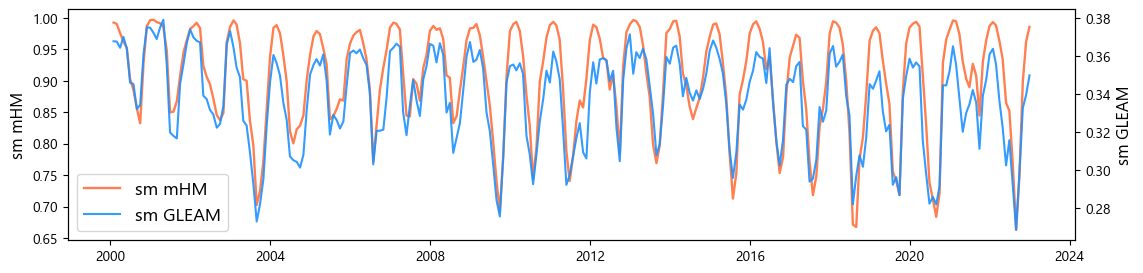

In [12]:
fig, ax = plt.subplots(figsize=(13, 3.0))
ax2=ax.twinx()
#mhm soil moisture
ax.plot(mhm_sm_ts[gleam_sm_ts.index.min():mhm_sm_ts.index.max()], c='coral', lw=1.7, label='sm mHM')
ax2.plot(gleam_sm_ts[gleam_sm_ts.index.min():mhm_sm_ts.index.max()], c='dodgerblue', lw=1.5, label='sm GLEAM', alpha=0.9)
ax.set_ylabel('sm mHM', fontsize=12)
ax2.set_ylabel('sm GLEAM', fontsize=12)
plt.xticks(fontsize=15)
#collect legend handles and labels
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles + handles2, labels + labels2, fontsize=13)


In [13]:
mhm_fluxes.data_vars

Data variables:
    lon_bnds      (time, lon, bnds) float64 2.0 2.031 2.031 ... 6.969 6.969 7.0
    lat_bnds      (time, lat, bnds) float64 51.97 52.0 51.94 ... 48.5 48.53
    interception  (time, lat, lon) float64 nan nan nan ... 0.1191 0.1323 0.1324
    snowpack      (time, lat, lon) float64 nan nan nan ... 0.7329 0.74 0.7411
    SWC_L01       (time, lat, lon) float64 nan nan nan nan ... 36.67 37.03 36.92
    SWC_L02       (time, lat, lon) float64 nan nan nan nan ... 72.05 72.57 72.38
    SWC_L03       (time, lat, lon) float64 nan nan nan nan ... 102.8 102.8 102.6
    SWC_L04       (time, lat, lon) float64 nan nan nan nan ... 126.2 125.6 125.3
    SWC_L05       (time, lat, lon) float64 nan nan nan nan ... 255.8 250.2 248.9
    SWC_L06       (time, lat, lon) float64 nan nan nan nan ... 466.7 443.2 438.8
    SM_L01        (time, lat, lon) float64 nan nan nan ... 0.9975 0.9973 0.9974
    SM_L02        (time, lat, lon) float64 nan nan nan ... 0.9805 0.9766 0.9774
    SM_L03        (time,

In [14]:
r2 = np.corrcoef(gleam_sm_ts['SMrz'][mhm_sm_ts.index.min():mhm_sm_ts.index.max()],
                  mhm_sm_ts['SM_L03'][mhm_sm_ts.index.min():mhm_sm_ts.index.max()])[0,1]**2
r2

KeyError: 'SM_L03'

In [ ]:
#scatter plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(gleam_sm_ts[mhm_sm_ts.index.min():mhm_sm_ts.index.max()],
           mhm_sm_ts[mhm_sm_ts.index.min():mhm_sm_ts.index.max()], s=8,c='C12')
ax.plot([gleam_sm_ts.min(), gleam_sm_ts.max()], [mhm_sm_ts.min(), mhm_sm_ts.max()], 'k--')
ax.set_ylabel('simulated sm')
ax.set_xlabel('observed sm')

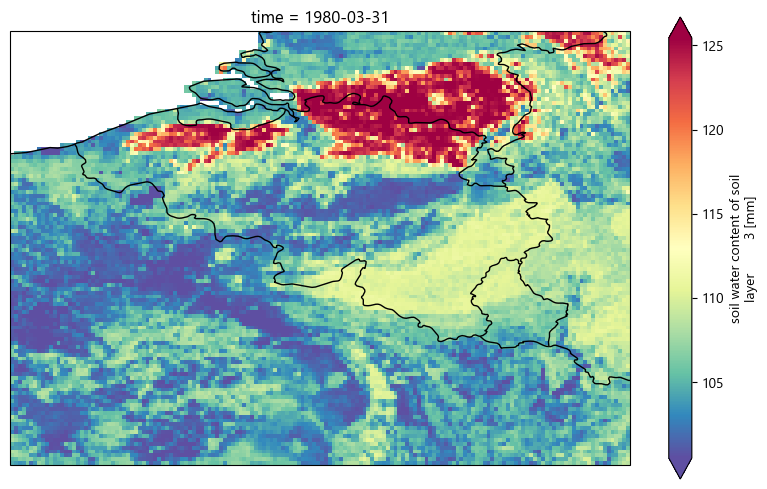

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))
sm_data = mhm_fluxes['SWC_L03'][122]
sm_data.plot(ax=ax, cmap='Spectral_r', robust=True, transform=ccrs.PlateCarree())

# Add a background map
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.LAND, facecolor='0.9')

In [ ]:
#resample to month ends
mhm_monthly_recharge = mhm_fluxes['recharge'].resample(time='ME').sum()
mhm_mon_average_recharge = mhm_monthly_recharge.groupby('time.month').mean(dim='time')
mhm_annual_recharge = mhm_monthly_recharge.groupby('time.year').sum()

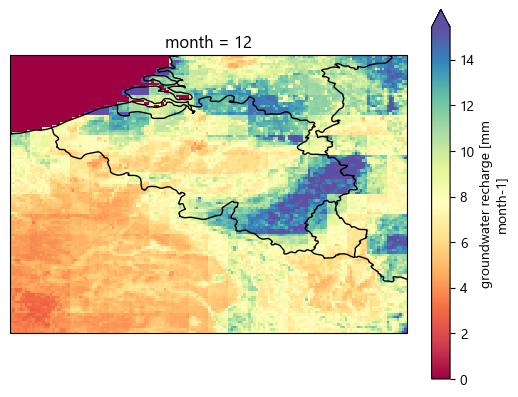

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
data = mhm_mon_average_recharge[11]
data.plot(ax=ax, cmap='Spectral', robust=True, transform=ccrs.PlateCarree())

# Add a background map
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.LAND, facecolor='0.9')

In [ ]:
mhm_mon_average_recharge[0].max()

<xarray.DataArray 'recharge' ()>
array(35.9696585)
Coordinates:
    month    int64 1